## US presidential elections model

How do macroeconomic features influence the left/right lean in US presidential elections? 

### Imports

In [1]:
# Misc system tools
from pathlib import Path
import subprocess 
# Usual data science stuff 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ML models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Internal modules
from train import Train
from analyse import Analyse

## Load preprocessed data

`code/process_data.py` runs preprocessing

Contains merged data from three sources (1960-2020):
- Election outcomes (winner, party, lean, label)
- World Bank macroeconomic indicators (GDP growth, inflation, trade balance, etc.)
- FRED unemployment rates (monthly data aggregated to yearly averages)

Missing values handled by:
- Dropping columns with >50% missing data
- Linear interpolation for remaining gaps
- Dropping any columns that still have missing values after interpolation

In [2]:
file_path = "../data/proc/data.csv" 
if not Path(file_path).is_file():
    subprocess.run(["python3", "process_data.py"])  
df = pd.read_csv(file_path)
display(df)

,Year,Winner,Party,EC,PV,Lean,Era,Label,index,"Population, total",...,Mobile cellular subscriptions (per 100 people),Merchandise trade (% of GDP),Net barter terms of trade index (2015 = 100),Net migration,"Personal remittances, paid (current US$)","Foreign direct investment, net inflows (BoP, current US$)",GDP per capita (current US$),"Foreign direct investment, net (BoP, current US$)","Inflation, consumer prices (annual %)",Unemployment
0,2024,Donald Trump,Republican,0.4200,0.4834,Right,Populist,1,64,334914895,...,104.935375,18.733583,100.000000,1322668,9.303100e+10,3.487840e+11,82769.412210,1.053000e+11,4.116338,4.027273
1,2020,Joseph Biden,Democratic,0.5688,0.5131,Left,Populist,0,61,331526933,...,104.935375,17.944405,100.000000,329769,6.612600e+10,1.370660e+11,64411.373180,1.452650e+11,1.233584,8.091667
2,2016,Donald Trump,Republican,0.5690,0.4620,Right,Populist,1,57,323071755,...,103.370250,19.681904,100.083472,1889129,6.287000e+10,4.743880e+11,58206.614190,-1.745730e+11,1.261583,4.875000
3,2012,Barack Obama,Democratic,0.6170,0.5110,Left,Partisan Polarisation,0,53,313877662,...,96.269297,23.884792,94.680851,1632007,5.237100e+10,2.503450e+11,51784.411470,1.268950e+11,2.069337,8.075000
4,2008,Barack Obama,Democratic,0.6780,0.5290,Left,Partisan Polarisation,0,49,304093966,...,85.477380,23.405290,91.797166,1416841,5.567900e+10,3.410920e+11,48570.059430,2.491000e+09,3.839100,5.800000
5,2004,George W. Bush,Republican,0.5320,0.5070,Right,Partisan Polarisation,1,45,292805298,...,62.874751,19.157874,101.270772,1313467,4.435700e+10,2.136410e+11,41724.641200,1.603630e+11,2.677237,5.541667
6,2000,George W. Bush,Republican,0.5040,0.4790,Right,Post-Cold War,1,41,282162411,...,38.767207,19.912473,100.000000,1248392,3.439700e+10,3.491250e+11,36329.970260,-1.627550e+11,3.376857,3.966667
7,1996,William Clinton,Democratic,0.7040,0.4920,Left,Post-Cold War,0,37,269394000,...,16.373812,17.924887,103.448276,1141648,2.372320e+10,9.766000e+10,29967.712720,5.360000e+09,2.931204,5.408333
8,1992,William Clinton,Democratic,0.6880,0.4300,Left,Post-Cold War,0,33,256514000,...,4.323597,15.368646,103.603604,1304880,1.615630e+10,3.031000e+10,25418.990780,2.846000e+10,3.028820,7.491667
9,1988,George Bush,Republican,0.7920,0.5340,Right,Post-1960s Realignment,1,29,244499000,...,0.854125,14.933243,103.960396,460778,9.005000e+09,5.691000e+10,21417.011930,-3.520900e+10,4.077741,5.491667


## Analyse features

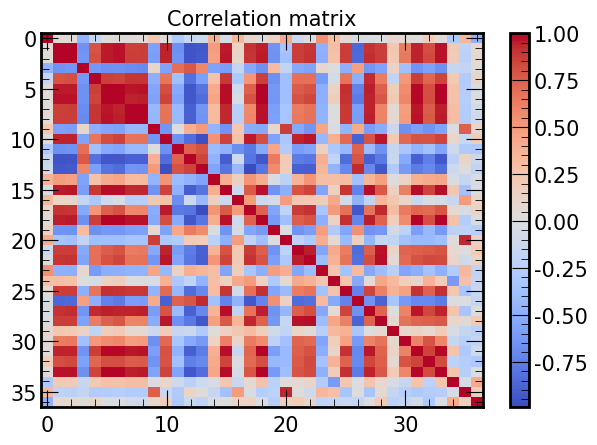

,Feature,Correlation
0,Label,1.000000
1,Gross capital formation (% of GDP),0.544342
2,"Inflation, GDP deflator (annual %)",0.412917
3,"Immunization, measles (% of children ages 12-2...",0.367727
4,Energy use (kg of oil equivalent per capita),0.340180
5,"Inflation, consumer prices (annual %)",0.333160
6,"Revenue, excluding grants (% of GDP)",0.288543
7,Income share held by lowest 20%,0.222303
8,"Foreign direct investment, net inflows (BoP, c...",0.186706
9,GDP growth (annual %),0.145926


In [3]:
# Analyse correlations with target variable
exclude_columns = ["Year", "Winner", "Party", "EC", "PV", "Era", "Lean"]
df_train = df.drop(columns=exclude_columns)

# Calculate correlation matrix
corr_matrix = df_train.corr()

# Plot
plt.figure()
plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Show correlations with target label
corr_with_label = corr_matrix["Label"].sort_values(ascending=False)
corr_df = pd.DataFrame({
    "Feature": corr_with_label.index,
    "Correlation": corr_with_label.values
})

display(corr_df)

## Training data

In [4]:
X = df_train.drop(columns=["Label"])
y = df_train["Label"]

print(f"{X.shape[1]} features, {X.shape[0]} samples")

36 features, 17 samples


## Baseline logitistic regression


In [5]:
trainer = Train(X=X, y=y, model=LogisticRegression)

>**Note:** This baseline model is quite unstable. With only 17 elections and a 20% test split (3-4 elections), which specific elections end up in the test set dramatically affects performance. This is why LOOCV is used below for more reliable evaluation.

🚀 Training model: LogisticRegression
  Tag: lr-base
  Random state: 42
  Leave-One-Out CV: False
  Test size: 0.2
  Save output: False
  hyperparams: {}

  Test size: 0.2

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,2,0
True 1,1,1



⭐ Classification report:



,precision,recall,f1-score,support
0,0.666667,1.00,0.800000,2.00
1,1.000000,0.50,0.666667,2.00
accuracy,0.750000,0.75,0.750000,0.75
macro avg,0.833333,0.75,0.733333,4.00
weighted avg,0.833333,0.75,0.733333,4.00



⭐ ROC curve:



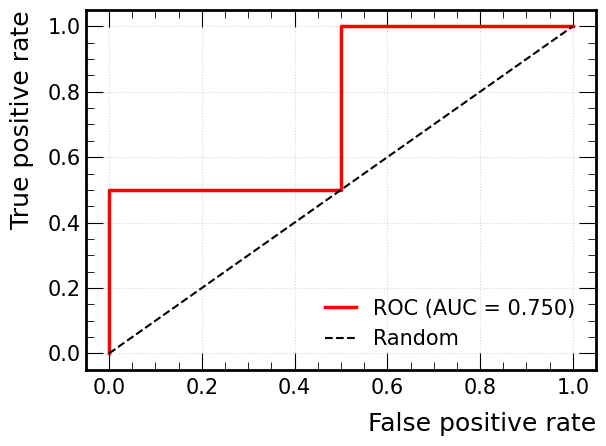

In [6]:
results = trainer.train(
    loocv=False,
    random_state=42,
    test_size=0.2,
    tag = "lr-base",
)

Analyse(results).execute()

## Logistic regression with leave-one-out cross validation (LOOCV)

Run with a test size of one in all combinations and get the average performance.

🚀 Training model: LogisticRegression
  Tag: lr-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}

✅ Training complete.

⭐ Confusion matrix:

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.555556,0.625000,0.588235,8.000000
1,0.625000,0.555556,0.588235,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.590278,0.590278,0.588235,17.000000
weighted avg,0.592320,0.588235,0.588235,17.000000



⭐ ROC curve:



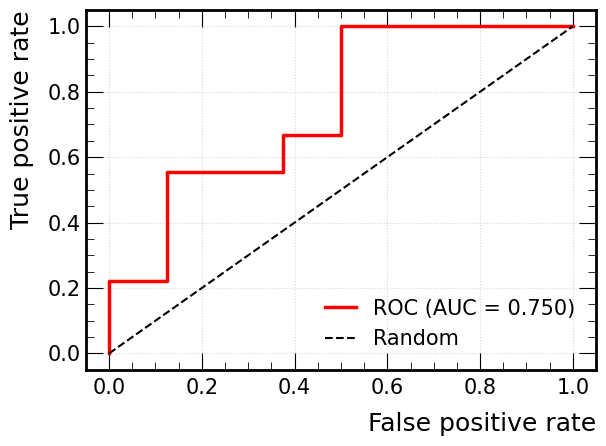

In [7]:
results = trainer.train(
    loocv=True,
    random_state=42,
    tag = "lr-loocv", 
)
# Analysis
Analyse(results).execute() 

## Random forest classifier with LOOCV

🚀 Training model: RandomForestClassifier
  Tag: rf-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {}



✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.625000,0.625000,0.625000,8.000000
1,0.666667,0.666667,0.666667,9.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.645833,0.645833,0.645833,17.000000
weighted avg,0.647059,0.647059,0.647059,17.000000



⭐ ROC curve:



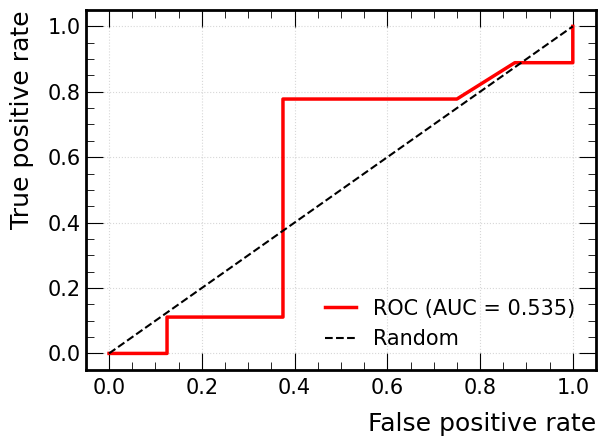

In [8]:
trainer = Train(X=X, y=y, model=RandomForestClassifier)

results = trainer.train(
    loocv=True,
    random_state=42,
    tag = "rf-loocv", 
)
# Analysis
Analyse(results).execute() 

🚀 Training model: SVC
  Tag: svc-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {'probability': True, 'kernel': 'linear'}

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,5,3
True 1,4,5



⭐ Classification report:



,precision,recall,f1-score,support
0,0.555556,0.625000,0.588235,8.000000
1,0.625000,0.555556,0.588235,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.590278,0.590278,0.588235,17.000000
weighted avg,0.592320,0.588235,0.588235,17.000000



⭐ ROC curve:



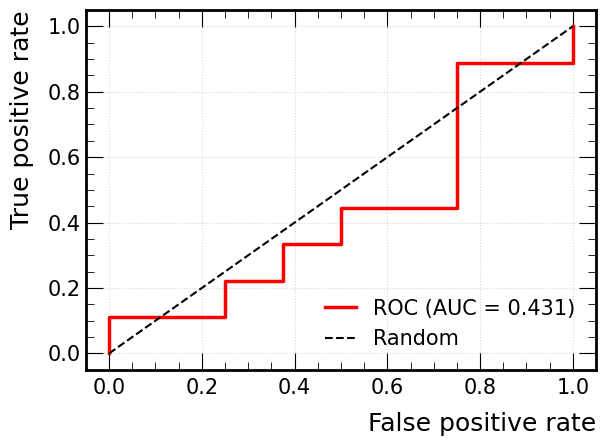

In [11]:
trainer = Train(X=X, y=y, model=SVC)
results = trainer.train(
    loocv=True,
    random_state=42,
    tag = "svc-loocv", 
    probability=True,
    kernel="linear"
)
# Analysis
Analyse(results).execute()

## Gradient boosted decision tree with LOOCV

🚀 Training model: XGBClassifier
  Tag: xgb-loocv
  Random state: 42
  Leave-One-Out CV: True
  Test size: 0.2
  Save output: False
  hyperparams: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

✅ Training complete.

⭐ Confusion matrix:

✅ Training complete.

⭐ Confusion matrix:



,Predicted 0,Predicted 1
True 0,4,4
True 1,3,6



⭐ Classification report:



,precision,recall,f1-score,support
0,0.571429,0.500000,0.533333,8.000000
1,0.600000,0.666667,0.631579,9.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.585714,0.583333,0.582456,17.000000
weighted avg,0.586555,0.588235,0.585346,17.000000



⭐ ROC curve:



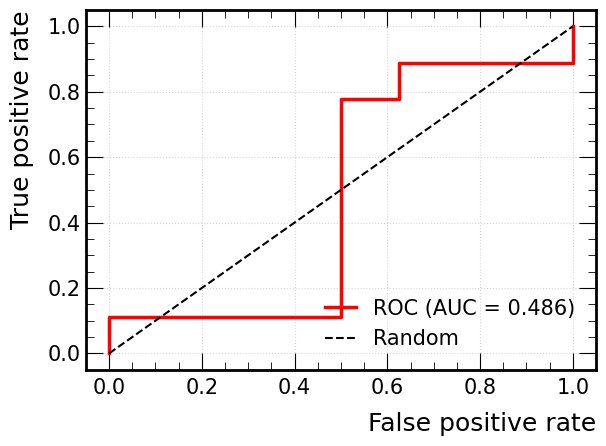

In [14]:
trainer = Train(X=X, y=y, model=XGBClassifier)
results = trainer.train(
    loocv=True,
    random_state=42,
    tag="xgb-loocv",
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1
)
# Analysis
Analyse(results).execute() 